# Predicting Stock Prices with Deep Neural Networks

https://www.alphavantage.co/stock-prediction-deep-neural-networks-lstm/

Deep learning is part of a broader family of machine learning methods based on artificial neural networks, which are inspired by our brain's own network of neurons. Among the popular deep learning frameworks, Long short-term memory (LSTM) is a specialized architecture that can "memorize" patterns from historical sequences of data and extrapolate such patterns to future events.

Since the financial market is naturally comprised of historical sequences of equity prices, more and more quantitative researchers and finance professionals are using LTSM to model and predict market price movements. In this project, we will go through the end-to-end machine learning lifecycle of developing an LTSM model to predict stock market prices using Python (PyTorch) and Alpha Vantage APIs.

The project is grouped into the following sections, which are representative of a typical machine learning workflow:

❚ Installing Python dependencies

❚ Data preparation: acquiring data from Alpha Vantage stock APIs

❚ Data preparation: normalizing raw data

❚ Data preparation: generating training and validation datasets

❚ Defining the LSTM model

❚ Model training

❚ Model evaluation

❚ Predicting future stock prices

By the end of this project, you will have a fully functional LSTM model that predicts future stock prices based on historical price movements, all in a single Python file. This tutorial has been written in a way such that all the essential code snippets have been embedded inline. You should be able to develop, train, and test your machine learning model without referring to other external pages or documents.

Let's get started!

## Installing Python dependencies
We recommend using **Python 3.6 or higher** for this project. If you do not have Python installed in your local environment, please visit python.org for the latest download instruction.

With Python installed, please go to the Command Line interface of your operating system and use the "pip install" prompts below to install Numpy, PyTorch, Matplotlib, and Alpha Vantage, respectively:

❚ numpy: pip install numpy

❚ PyTorch: pip install torch

❚ matplotlib: pip install matplotlib

❚ alpha_vantage: pip install alpha_vantage

Now, create a new Python file named project.py and paste the following code into the file:

In [1]:
import os
! pip install numpy torch matplotlib alpha_vantage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 47.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 4.5 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.0/245.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.5 MB/s eta 0:00:00a 0:00:01


In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries

print("All libraries loaded")

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/GeniusAI/GeniusChatbots/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


All libraries loaded


If your have successfully installed all the Python dependencies above, you should see the text "All libraries loaded" after running the project.py file.

Now append the following code to the project.py file. Don't forget to replace "YOUR_API_KEY" with your actual Alpha Vantage API key, which can be obtained from the Alpha Vantage support page.

此处将会使用环境变量获取Alpha Vantage API key

In [2]:
import os
alpha_vantage_api_key = os.getenv("ALPHA_VANTAGE_API_KEY")


In [23]:
config = {
    "alpha_vantage": {
        "key": "demo", # you can use the demo API key for this project, but please make sure to get your own API key at https://www.alphavantage.co/support/#api-key
        "symbol": "TSLA",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    },
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Over the course of this project, we will continue adding new code blocks to the project.py file. By the time you reach the end of the tutorial, you should have a fully functional LSTM machine learning model to predict stock market price movements, all in a single Python script. Please feel free to compare your project.py with the source code if you would like to have a "sanity check" anytime during the project.

## Data preparation: acquiring data from Alpha Vantage stock APIs
In this project, we will train an LSTM model to predict stock price movements. Before we can build the "crystal ball" to predict the future, we need historical stock price data to train our deep learning model. To this end, we will query the Alpha Vantage stock API via a popular Python wrapper (optionally, please refer to this market data API review across multiple asset classes such as equities, forex, and technical indicators). For this project, we will obtain over 20 years of daily close prices for IBM from November 1999 to April 29, 2021.

Append the following code block to your project.py file. If you re-run the file now, it should generate a graph similar to above thanks to the powerful matplotlib library.

In [26]:
def download_data(config):
    # ts = TimeSeries(key='demo')
    ts = TimeSeries(key=alpha_vantage_api_key)
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])
    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.show()


ValueError: Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints

> Error:
> **ValueError: keyword grid_b is not recognized; valid keywords are** ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']
>
https://blog.csdn.net/ZHANG_1013/article/details/138871332
网上查了一下说有可能是版本问题，卸载后重新安装了其他版本的matplotlib就好了

pip install matplotlib==3.2.1

https://github.com/ricequant/rqalpha/issues/772
plot时会报错，keyword grid_b is not recognized
根据matplotlib3.7的release notes,

The first parameter of Axes.grid and Axis.grid has been renamed to visible
The parameter was previously named b. This name change only matters if that parameter was passed using a keyword argument, e.g. grid(b=False).
所以， rqalpha/mod/rqalpha_mod_sys_analyser/plot/plot.py中的 grid(b=True...） 需要修改为grid(True...)

**最终解决：** 将参数由b换成visible

## Data preparation: normalizing raw financial data
Machine learning algorithms (such as our LSTM algorithm) that use gradient descent as the optimization technique require data to be scaled. This is due to the fact that the feature values in the model will affect the step size of the gradient descent, potentially skewing the LSTM model in unexpected ways.

This is where **data normalization** comes in. Normalization can increase the accuracy of your model and help the gradient descent algorithm converge more quickly. By bringing the input data on the same scale and reducing its variance, none of the weights in the artificial neural network will be wasted on normalizing tasks, which means the LSTM model can more efficiently learn from the data and store patterns in the network. Furthermore, LSTMs are intrinsically sensitive to the scale of the input data. For the above reasons, it is crucial to normalize the data.

Since stock prices can range from tens to hundreds and thousands - $40 to $160 per share in the case of IBM - we will perform normalization on the stock prices to standardize the range of these values before feeding the data to the LSTM model. The following code snippet rescales the data to have a mean of 0 and the standard deviation is 1.

Append the following data normalization code block to your project.py file.

In [12]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)
print(normalized_data_close_price)

[-1.11300705 -1.1437903  -1.15077207 ...  2.50933901  2.53460597
  2.59037817]


## Data preparation: generating training and validation datasets
[Supervised machine learning methods](https://en.wikipedia.org/wiki/Supervised_learning) such as LSTM learns the mapping function from input variables (X) to the output variable (Y). Learning from the training dataset can be thought of as a teacher supervising the learning process, where the teacher knows all the right answers.

In this project, we will train the model to predict the 21st day's close price based on the past 20 days' close prices. The number of days, 20, was selected based on a few reasons:

❚ When LSTM models are used in natural language processing, the number of words in a sentence typically ranges from 15 to 20 words

❚ Gradient descent considerations: attempting to back-propagate across very long input sequences may result in vanishing gradients (more on this later)

❚ Longer sequences tend to have much longer training times

After transforming the dataset into input features and output labels, the shape of our X is (5388, 20), with 5388 being the number of rows and each row containing a sequence of past 20 days' prices. The corresponding Y data shape is (5388,), which matches the number of rows in X.

We also split the dataset into two parts, for training and validation. We split the data into 80:20 - 80% of the data is used for training, with the remaining 20% for validating our model's performance in predicting future prices. (Alternatively, another common practice is to split the initial data into train, validation, and test set in a 70/20/10 allocation, where the test dataset is not used at all during the training process.) The following graph shows the portion of data for training and validation - roughly speaking, data before ~2017 are used for training and data after ~2017 are used for model performance validation.

Append the following code block to your project.py file. If you re-run the file now, it should generate a graph similar to above, where the training data is colored in green and validation data is colored in blue.

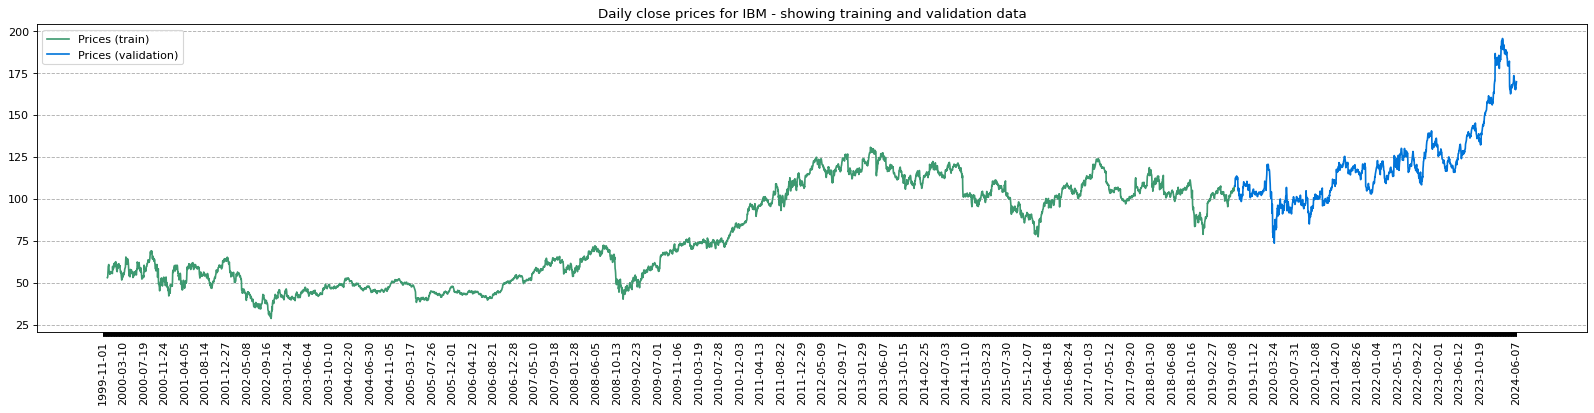

In [14]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

# prepare data for plotting

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

## plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

We will train our models using the [PyTorch](https://pytorch.org/) framework, a machine learning library written in Python. At the heart of PyTorch's data loading utility is the [DataLoader](https://pytorch.org/docs/stable/data.html) class, an efficient data generation scheme that leverages the full potential of your computer's Graphics Processing Unit (GPU) during the training process where applicable. `DataLoader` requires the [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) object to define the loaded data. `Dataset` is a map-style dataset that implements the `__getitem__()` and `__len__()` protocols, and represents a map from indices to data samples.

Append the following code block to your project.py file to implement the data loader functionality.

In [15]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (4936, 20, 1) (4936,)
Validation data shape (1234, 20, 1) (1234,)


## Defining the LSTM model
With the training and evaluation data now fully normalized and prepared, we are ready to build our LSTM model!

As mentioned before, LSTM is a specialized artificial neural network architecture that can "memorize" patterns from historical sequences of data and extrapolate such patterns for future events. Specifically, it belongs to a group of artificial neural networks called Recurring Neural Networks (RNNs).

LSTM is a popular artificial neural network because it manages to overcome many technical limitations of RNNs. For example, RNNs fail to learn when the data sequence is greater than 5 to 10 due to the vanishing gradients problem, where the gradients are vanishingly small, effectively preventing the model from learning. LSTMs can learn long sequences of data by enforcing constant error flow through self-connected hidden layers, which contain memory cells and corresponding gate units. If you are interested in learning more about the inner workings of LSTM and RNNs, this is an excellent explainer for your reference.

Our artificial neural network will have three main layers, with each layer designed with a specific logical purpose:

❚ linear layer 1 (linear_1): to map input values into a high dimensional feature space, transforming the features for the LSTM layer

❚ LSTM (lstm): to learn the data in sequence

❚ linear layer 2 (linear_2): to produce the predicted value based on LSTM's output

We also add Dropout, where randomly selected artificial neurons are ignored during training, therefore regularizing the network to prevent overfitting and improving overall model performance. As an optional step, we also initialize the LSTM's model weights, as some researchers have observed that it could help the model learn more efficiently.

Append the following code block to your project.py file to specify the LSTM model.

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

## Model training
The LSTM model learns by iteratively making predictions given the training data X. We use mean squared error as the cost function, which measures the difference between the predicted values and the actual values. When the model is making bad predictions, the error value returned by the cost function will be relatively high. The model will fine-tune its weights through backpropagation, improving its ability to make better predictions. Learning stops when the algorithm achieves an acceptable level of performance, where the error value returned by the cost function on the validation dataset is no longer showing incremental improvements.

We use the Adam optimizer that updates the model's parameters based on the learning rate through its step() method. This is how the model learns and fine-tunes its predictions. The learning rate controls how quickly the model converges. A learning rate that is too high can cause the model to converge too quickly to a suboptimal solution, whereas smaller learning rates require more training iterations and may result in prolonged duration for the model to find the optimal solution. We also use the StepLR scheduler to reduce the learning rate during the training process. You may also try the ReduceLROnPlateau scheduler, which reduces the learning rate when a cost function has stopped improving for a "patience" number of epochs. Choosing the proper learning rate for your project is both art and science, and is a heavily researched topic in the machine learning community.

Append the following code block to your project.py file and re-run the file to start the model training process.

In [17]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.039387, test:0.045610 | lr:0.010000
Epoch[2/100] | loss train:0.008860, test:0.024362 | lr:0.010000
Epoch[3/100] | loss train:0.008785, test:0.019599 | lr:0.010000
Epoch[4/100] | loss train:0.007496, test:0.015281 | lr:0.010000
Epoch[5/100] | loss train:0.008064, test:0.016036 | lr:0.010000
Epoch[6/100] | loss train:0.007312, test:0.018387 | lr:0.010000
Epoch[7/100] | loss train:0.007389, test:0.017898 | lr:0.010000
Epoch[8/100] | loss train:0.006586, test:0.019157 | lr:0.010000
Epoch[9/100] | loss train:0.007164, test:0.017267 | lr:0.010000
Epoch[10/100] | loss train:0.007978, test:0.011252 | lr:0.010000
Epoch[11/100] | loss train:0.008705, test:0.012826 | lr:0.010000
Epoch[12/100] | loss train:0.007171, test:0.010625 | lr:0.010000
Epoch[13/100] | loss train:0.007284, test:0.014353 | lr:0.010000
Epoch[14/100] | loss train:0.006672, test:0.013608 | lr:0.010000
Epoch[15/100] | loss train:0.008122, test:0.018702 | lr:0.010000
Epoch[16/100] | loss train:0.00667

Using mean squared error as the loss function to optimize our model, the above log output are step-by-step "loss" values calculated based on how well the model is learning. After every epoch, a smaller loss value indicates that the model is learning well, and 0.0 means that no mistakes were made. Loss train gives an idea of how well the model is learning, while loss test shows how well the model generalizes to the validation dataset. A well-trained model is identified by a training and validation loss that decreases to the point of negligible differences between the two final loss values (at this stage, we say the model has "converged"). Generally, the loss values of the model will be lower on the training than on the validation dataset.

## Model evaluation
To visually inspect our model's performance, we will use the newly trained model to make predictions on the training and validation datasets we've created earlier in this project. If we see that the model can predict values that closely mirror the training dataset, it shows that the model managed to memorize the data. And if the model can predict values that resemble the validation dataset, it has managed to learn the patterns in our sequential data and generalize the patterns to unseen data points.

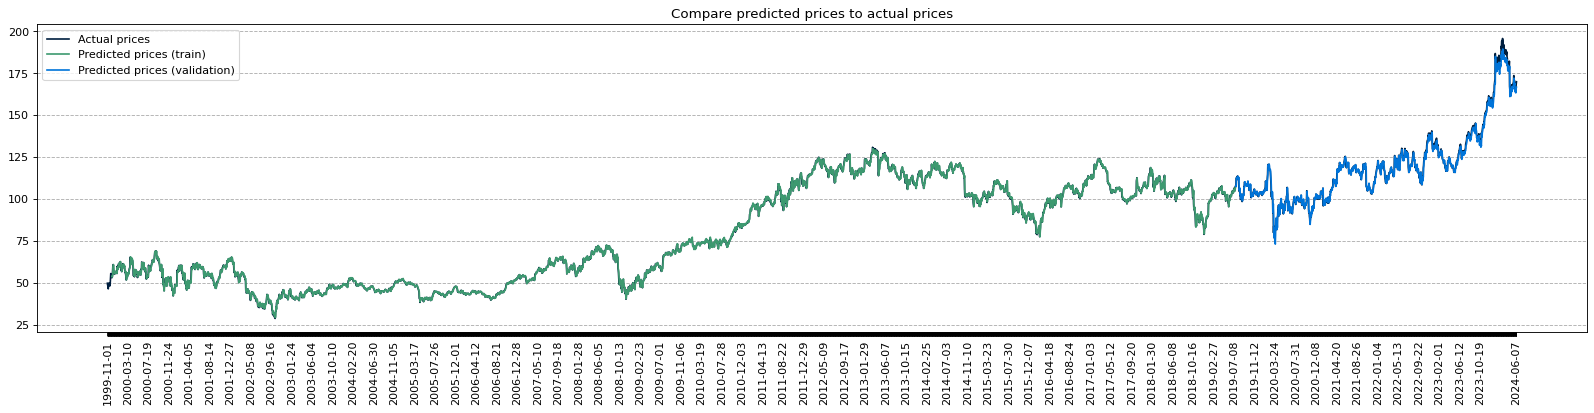

In [19]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

From our results, we can see that the model has managed to learn and predict on both training (green) and validation (blue) datasets very well, as the "Predicted prices" lines significantly overlap with the "Actual prices" values.

Let's zoom into the chart and look closely at the blue "Predicted price (validation)" segment by comparing it against the actual prices values.

Append the following code block to your project.py file and re-run the script to generate the zoomed-in graph.

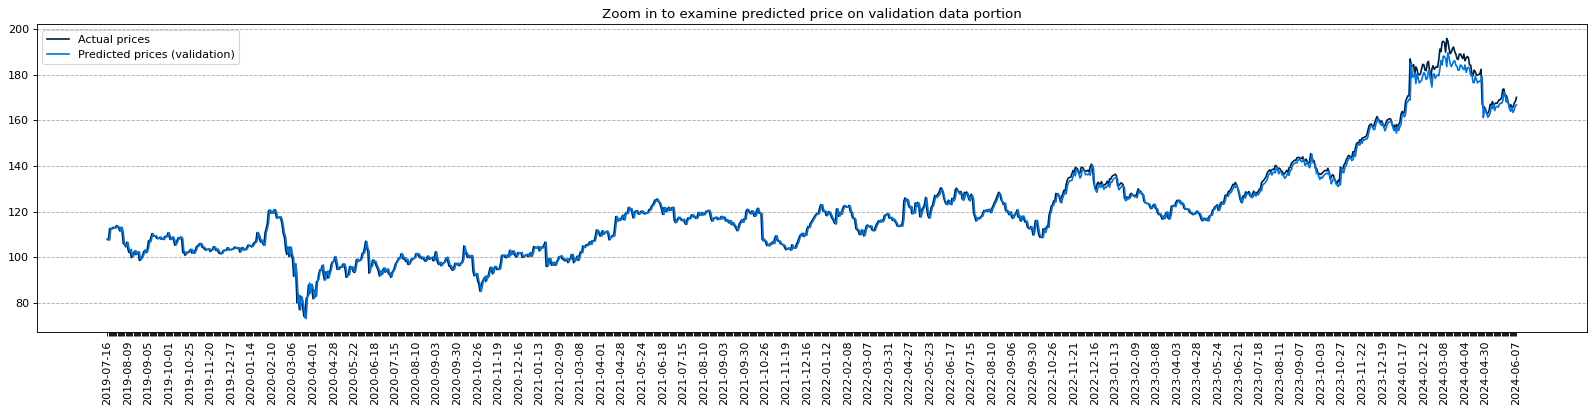

In [21]:
# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices

to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
to_plot_predicted_val = scaler.inverse_transform(predicted_val)
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

What a beautiful graph! You can see that the predicted prices (blue) significantly overlap with the actual prices (black) of IBM.

It is also worth noting that model training & evaluation is an iterative process. Please feel free to go back to the model training step to fine-tune the model and re-evaluate the model to see if there is a further performance boost.

## Predicting future stock prices
By now, we have trained an LSTM model that can (fairly accurately) predict the next day's price based on the past 20 days' close prices. This means we now have a crystal ball in hand! Let's supply the past 20 days' close prices to the model and see what it predicts for the next trading day (i.e., the future!). Append the following code to your project.py file and re-run the script one last time.

/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/ipykernel_36338/3874076405.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)


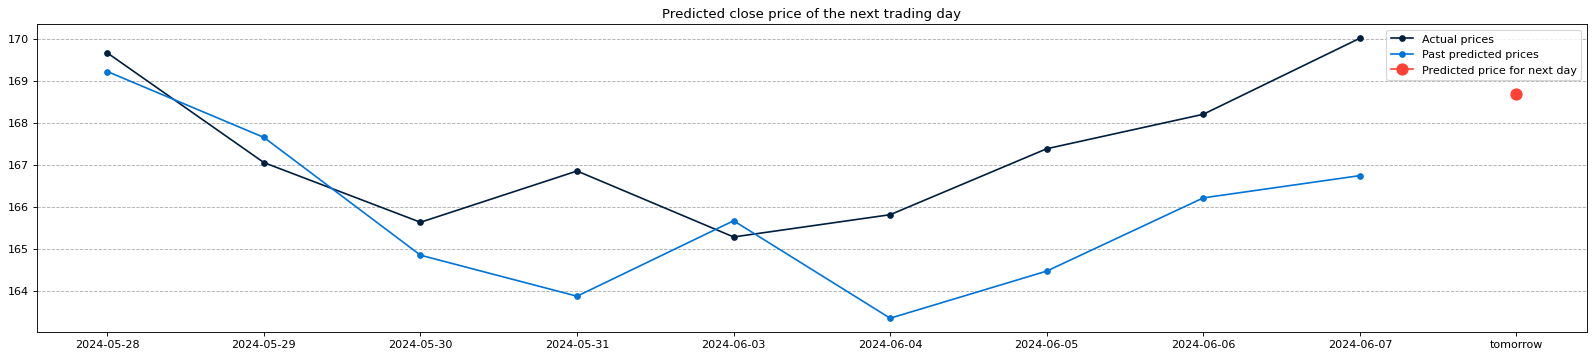

Predicted close price of the next trading day: 168.69


In [22]:
# predict the closing price of the next trading day

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]
plot_date_test.append("tomorrow")

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))

The red dot in the graph is what our model predicts for IBM's close price on the next trading day.

Is the prediction good enough? How about other stocks such as TSLA, APPL, or the Reddit-favorite Gamestop (GME)? What about other asset classes such as forex or cryptocurrencies? Beyond the close prices, are there any other external data we can feed to the LSTM model to make it even more robust - for example, one of the 50+ technical indicators from the Alpha Vantage APIs?

Now that you have learned the fundamentals of machine learning for financial market data, the possibility is limitless. We hereby pass the baton to you, our fearless reader!